In [1]:
%load_ext lab_black

# Project objective: Demand forecast (unit sales) for potential new products for "The Brand"


The Brand is a niche online boutique that develops designer products in partnership with other businesses and plans limited quantity flash sales for them.

Use case: An accurate demand prediction for a potential new product's sales event can help produce the right quantity of these products.


**Notebook objective: Read input files, do basic data cleansing and merge them**<br/>
Cleaning steps:<br/>
 - Checking duplicates<br/>
 - Fixing missing values<br/>

In [2]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import missingno as msno

In [3]:
pd.options.display.float_format = "{:.2f}".format
# pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 99)
pd.set_option("display.max_colwidth", 199)

In [4]:
base_dir = Path("/Users/igari/OneDrive/Documents/thebrand")
data = base_dir / "data"

# 1 - Reading input data with features

In [5]:
features = pd.read_csv(data / "product_articles_attributes.csv")

features.head(10)

,Article,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,MODEL,Sustainablity,MARKETING_CATEGORY
0,A1,TRFU,44.00,97528.00,1.00,GKD49,Organic materials,GK6
1,B2,AT2E,1.00,3030975.00,1.00,21972,Organic materials,2115
2,C3,TREU,39.00,303034.00,997.00,KYH28,Low carbon footprint,KY25
3,D4,TRK4,51.00,30305.00,400.00,GUP97,Reegrow,GU16
4,E5,TRK4,19.00,886.00,1.00,DBI07,Recycleable,DB7
5,F6,AT2F,1.00,9752975.00,1.00,GVT47,Vegan,GV13
6,G7,DO0N,78.00,30307.00,1.00,FTS61,Not Applicable,FT5
7,H8,AT2E,1.00,30934.00,689.00,FCF74,Vegan,FC0
8,I9,AT2E,1.00,30934.00,300.00,DBG98,Reegrow,DB18
9,J10,AT2E,161.00,3030975.00,1.00,AQT17,Primeblue nylon,AQ11


In [6]:
features.shape

(60671, 8)

In [7]:
features.dtypes

Article                   object
MATERIAL_CONTENT_CODE     object
PRODUCT_TYPES            float64
BUSINESS_SEGMENTS        float64
NRF_COLOR_CODE           float64
MODEL                     object
Sustainablity             object
MARKETING_CATEGORY        object
dtype: object

## Fixing the dtypes of categorical features.

In [8]:
# Article and model are not going to be used in the analysis further so skipping them.
for col in [
    "MATERIAL_CONTENT_CODE",
    "PRODUCT_TYPES",
    "BUSINESS_SEGMENTS",
    "NRF_COLOR_CODE",
    "Sustainablity",
    "MARKETING_CATEGORY",
]:
    features[col] = features[col].astype("category")

features.describe()

,Article,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,MODEL,Sustainablity,MARKETING_CATEGORY
count,60671,60665,60667.00,60667.00,60646.00,60670,60671,60671
unique,60671,435,153.00,85.00,257.00,14098,10,5475
top,A1,AT2E,1.00,3030975.00,1.00,DVF21,Primeblue nylon,GV12
freq,1,12861,23490.00,5759.00,21165.00,222,6136,121


High cardinality is going to be a challenge in modeling.

In [9]:
# Check missing values
features.isnull().sum()

Article                   0
MATERIAL_CONTENT_CODE     6
PRODUCT_TYPES             4
BUSINESS_SEGMENTS         4
NRF_COLOR_CODE           25
MODEL                     1
Sustainablity             0
MARKETING_CATEGORY        0
dtype: int64

We will deal with these missing values after merging all the input dataframes together.

# 2 - Read historical unit sales data

In [10]:
units = pd.read_csv(data / "historical_unit_sales.csv")

units.head(10)

,Article,Units_sold
0,J10,12
1,U21,12
2,E31,12
3,P42,12
4,C55,12
5,Q69,12
6,S71,12
7,W75,12
8,R96,12
9,U99,12


In [11]:
units.shape

(60675, 2)

<AxesSubplot:xlabel='Units_sold'>

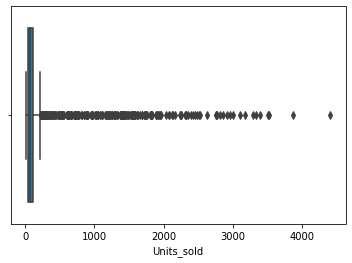

In [12]:
sns.boxplot(data=units, x="Units_sold")

We will deal with these outliers later.

# 3 - Reading the product popularity data that has 2 more KPIs per article

In [13]:
popularity = pd.read_csv(data / "historical_product_popularity.csv")

popularity.head(10)

,Article,Searches,Social_References
0,A1,193,97
1,B2,70,53
2,C3,211,53
3,D4,45,23
4,E5,183,137
5,F6,83,42
6,G7,220,55
7,H8,72,18
8,I9,211,53
9,J10,24,18


In [14]:
popularity.shape

(60675, 3)

<AxesSubplot:xlabel='Searches'>

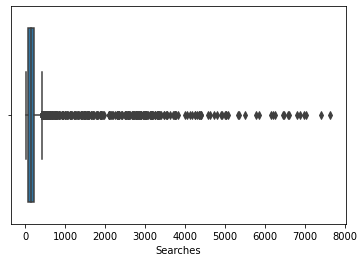

In [15]:
sns.boxplot(data=popularity, x="Searches")

<AxesSubplot:xlabel='Social_References'>

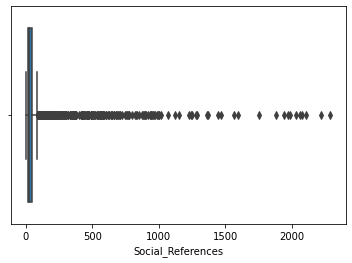

In [16]:
sns.boxplot(data=popularity, x="Social_References")

# Merging the 3 input dataframes together

In [17]:
df = features.merge(units, how="left", on="Article")

assert df.shape[0] == features.shape[0]
df.head()

,Article,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,MODEL,Sustainablity,MARKETING_CATEGORY,Units_sold
0,A1,TRFU,44.00,97528.00,1.00,GKD49,Organic materials,GK6,84
1,B2,AT2E,1.00,3030975.00,1.00,21972,Organic materials,2115,36
2,C3,TREU,39.00,303034.00,997.00,KYH28,Low carbon footprint,KY25,120
3,D4,TRK4,51.00,30305.00,400.00,GUP97,Reegrow,GU16,24
4,E5,TRK4,19.00,886.00,1.00,DBI07,Recycleable,DB7,96


In [18]:
df = df.merge(popularity, how="left", on="Article")

assert df.shape[0] == features.shape[0]
df.head()

,Article,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,MODEL,Sustainablity,MARKETING_CATEGORY,Units_sold,Searches,Social_References
0,A1,TRFU,44.00,97528.00,1.00,GKD49,Organic materials,GK6,84,193,97
1,B2,AT2E,1.00,3030975.00,1.00,21972,Organic materials,2115,36,70,53
2,C3,TREU,39.00,303034.00,997.00,KYH28,Low carbon footprint,KY25,120,211,53
3,D4,TRK4,51.00,30305.00,400.00,GUP97,Reegrow,GU16,24,45,23
4,E5,TRK4,19.00,886.00,1.00,DBI07,Recycleable,DB7,96,183,137


In [19]:
df.shape

(60671, 11)

# Data cleansing

In [20]:
# Double-checking if the dtypes look ok
df.dtypes

Article                    object
MATERIAL_CONTENT_CODE    category
PRODUCT_TYPES            category
BUSINESS_SEGMENTS        category
NRF_COLOR_CODE           category
MODEL                      object
Sustainablity            category
MARKETING_CATEGORY       category
Units_sold                  int64
Searches                    int64
Social_References           int64
dtype: object

## Missing values check

In [21]:
# Checking missing values again
df.isna().sum()

Article                   0
MATERIAL_CONTENT_CODE     6
PRODUCT_TYPES             4
BUSINESS_SEGMENTS         4
NRF_COLOR_CODE           25
MODEL                     1
Sustainablity             0
MARKETING_CATEGORY        0
Units_sold                0
Searches                  0
Social_References         0
dtype: int64

In [22]:
# We can afford to delete these missing values for now
df = df[~df.NRF_COLOR_CODE.isna()]
df = df[~df.MATERIAL_CONTENT_CODE.isna()]

df.isna().sum()

Article                  0
MATERIAL_CONTENT_CODE    0
PRODUCT_TYPES            0
BUSINESS_SEGMENTS        0
NRF_COLOR_CODE           0
MODEL                    1
Sustainablity            0
MARKETING_CATEGORY       0
Units_sold               0
Searches                 0
Social_References        0
dtype: int64

## Duplicates check

In [23]:
# Checking for any duplicate rows
df.drop_duplicates(keep="first", inplace=True)
df.shape

(60644, 11)

In [24]:
del features, units, popularity

In [25]:
output_path = data / "01_raw" / "src.csv"
df.to_parquet(output_path, index=None)